In [85]:

#2년치 데이터 가져와서 경기 당 평균으로 데이터프레임 합치기
import numpy as np
import pandas as pd

# Load the salary and stats data
salary_data = pd.read_csv('/content/all_salary_data.csv', encoding='latin1')
stats_data = pd.read_csv('/content/2010-2024_average(3).csv', encoding='latin1')

# Define the new columns to be added to salary_data
new_columns = ['Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
               'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

# Add new columns to salary_data, initializing with None
for col in new_columns:
    salary_data[col] = None

# Define the maximum range of years to look back
max_year_range = 2

# Process each row in salary_data
for idx, row in salary_data.iterrows():
    player_name = row['name']
    start_year = row['start']

    # Initialize an empty DataFrame to store the filtered stats
    filtered_stats = pd.DataFrame()

    # Check for each year in the range from start_year to start_year-max_year_range+1
    for i in range(max_year_range):
        year = start_year - i
        yearly_stats = stats_data[(stats_data['name'] == player_name) & (stats_data['year'] == year)]
        if not yearly_stats.empty:
            filtered_stats = pd.concat([filtered_stats, yearly_stats])
            # Stop if we've included up to the desired number of years
            if len(filtered_stats['year'].unique()) >= max_year_range:
                break

    if not filtered_stats.empty:
        # Add the 'Pos' column value from the first row of filtered_stats
        salary_data.at[idx, 'Pos'] = filtered_stats.iloc[0]['Pos']

        # Calculate weighted averages for the remaining columns using 'G' as the weight
        total_games = filtered_stats['G'].sum()
        for col in new_columns[1:]:
            if col in filtered_stats.columns:
                salary_data.at[idx, col] = (filtered_stats[col] * filtered_stats['G']).sum() / total_games
            else:
                salary_data.at[idx, col] = None

# Drop rows with any missing values
salary_data.dropna(inplace=True)
nba_data = salary_data

# Save the updated data to a new CSV file
salary_data.to_csv('/content/final_nba_data(3).csv', index=False)

In [86]:
# 중복된년수(여러번 계약) 평균으로 보정하기
def weighted_average(group):
    weights = group['G']
    weighted_stats = group.drop(columns=['name', 'debut', 'start', 'end', 'salary', 'birth', 'target', 'Pos']).apply(lambda x: (x * weights).sum() / weights.sum())
    weighted_stats['name'] = group['name'].iloc[0]
    weighted_stats['debut'] = group['debut'].iloc[0]
    weighted_stats['start'] = group['start'].iloc[0]
    weighted_stats['end'] = group['end'].iloc[0]
    weighted_stats['salary'] = group['salary'].mean()  # Taking the mean of salary
    weighted_stats['birth'] = group['birth'].iloc[0]
    weighted_stats['target'] = group['target'].iloc[0]
    weighted_stats['Pos'] = group['Pos'].iloc[0]
    weighted_stats['G'] = group['G'].sum()  # Accumulate the total number of games
    return weighted_stats

# Selecting only the stats columns for averaging
stats_columns = ['GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
                 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

# Group by 'name' and 'start' and calculate the weighted average of stats
weighted_nba_data = nba_data.groupby(['name', 'start']).apply(
    lambda group: pd.Series({col: (group[col] * group['G']).sum() / group['G'].sum() for col in stats_columns})
).reset_index()

# Add back the columns that are not averaged
weighted_nba_data['name'] = nba_data.groupby(['name', 'start'])['name'].first().values
weighted_nba_data['debut'] = nba_data.groupby(['name', 'start'])['debut'].first().values
weighted_nba_data['start'] = nba_data.groupby(['name', 'start'])['start'].first().values
weighted_nba_data['end'] = nba_data.groupby(['name', 'start'])['end'].first().values
weighted_nba_data['salary'] = nba_data.groupby(['name', 'start'])['salary'].mean().values
weighted_nba_data['birth'] = nba_data.groupby(['name', 'start'])['birth'].first().values
weighted_nba_data['target'] = nba_data.groupby(['name', 'start'])['target'].first().values
weighted_nba_data['Pos'] = nba_data.groupby(['name', 'start'])['Pos'].first().values
weighted_nba_data['G'] = salary_data.groupby(['name', 'start'])['G'].first().values
# Save the cleaned data to a new CSV file
nba_data.to_csv('/content/final_nba_data(3).csv', index=False)



# Perform one-hot encoding for 'Pos' column
positions = ['PG', 'SG', 'SF', 'PF', 'C']
nba_data['Pos'] = pd.Categorical(nba_data['Pos'], categories=positions)

# Get dummies for positions
pos_dummies = pd.get_dummies(nba_data['Pos'], prefix='Pos', dummy_na=False)

# Ensure the dataframe only has the 5 position columns
pos_dummies = pos_dummies.reindex(columns=[f'Pos_{pos}' for pos in positions], fill_value=0)

# Concatenate the one-hot encoded positions back to the dataframe
nba_data = pd.concat([weighted_nba_data, pos_dummies], axis=1)

# Save the updated data with one-hot encoding to a new CSV file
nba_data.to_csv('/content/final_nba_data(3).csv', index=False)

nba_data['contract_period'] = (nba_data['end'] - nba_data['start']) + 1

nba_data.dropna(inplace=True)
# Save the updated data with the new feature to a new CSV file
nba_data.to_csv('/content/final_nba_data(3).csv', index=False)





In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv('/content/final_nba_data.csv',encoding='ISO-8859-1')
data= data.dropna()
data.to_csv('/content/final_nba_data(2).csv', index=False)

Linear Regression - Mean Squared Error: 0.0016412068626012921, R^2 Score: 0.7659855666208836
Ridge Regression - Mean Squared Error: 0.0016291701042844167, R^2 Score: 0.7677018494621461
Lasso Regression - Mean Squared Error: 0.002111157413712563, R^2 Score: 0.698976821751149


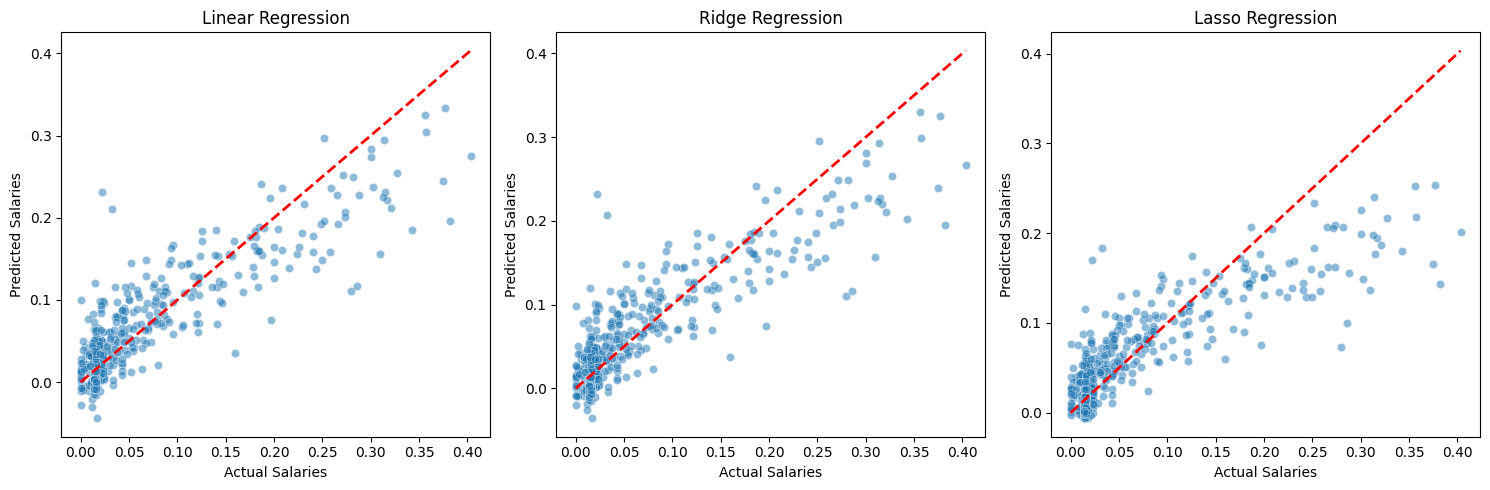

In [11]:
#linear ,ridge,lassp로 평가하기

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('/content/final_nba_data2.csv')

# Display the first few rows of the dataset to check the data

# Define X and y
X = data.drop(['target','salary','name','ORB','Pos','start','end','birth'],axis=1)
y = data['target']

X.head()


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Make predictions with Linear Regression
y_pred_linear = linear_model.predict(X_test_scaled)

# Initialize and train the Ridge regression model
ridge_model = Ridge(alpha=5) #높은 패널티 계수 부여
ridge_model.fit(X_train_scaled, y_train)

# Make predictions with Ridge Regression
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Initialize and train the Lasso regression model
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train_scaled, y_train)

# Make predictions with Lasso Regression
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Calculate evaluation metrics
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f'Linear Regression - Mean Squared Error: {mse_linear}, R^2 Score: {r2_linear}')
print(f'Ridge Regression - Mean Squared Error: {mse_ridge}, R^2 Score: {r2_ridge}')
print(f'Lasso Regression - Mean Squared Error: {mse_lasso}, R^2 Score: {r2_lasso}')

# Visualize the results
plt.figure(figsize=(15, 5))

# Linear Regression Plot
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_test, y=y_pred_linear, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.title('Linear Regression')

# Ridge Regression Plot
plt.subplot(1, 3, 2)
sns.scatterplot(x=y_test, y=y_pred_ridge, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.title('Ridge Regression')

# Lasso Regression Plot
plt.subplot(1, 3, 3)
sns.scatterplot(x=y_test, y=y_pred_lasso, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.title('Lasso Regression')

plt.tight_layout()
plt.show()

In [9]:

X.shape

(1576, 32)

<ipython-input-12-c3184c5c2d1c>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_correlations, y=best_features, palette='viridis')


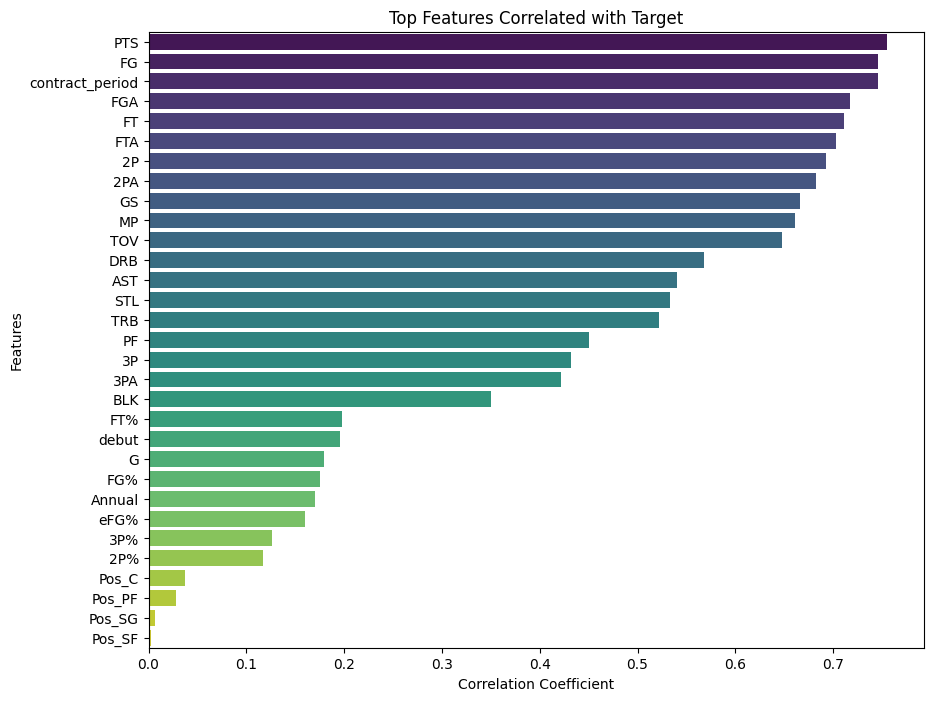

Top 31 Features R2 Score: 0.7663325983762012
Linear Regression - Mean Squared Error: 0.001638773034524349, R^2 Score: 0.7663325983762013
Ridge Regression - Mean Squared Error: 0.0016270489403329626, R^2 Score: 0.7680042994405827
Lasso Regression - Mean Squared Error: 0.0021115831002159312, R^2 Score: 0.6989161244751669


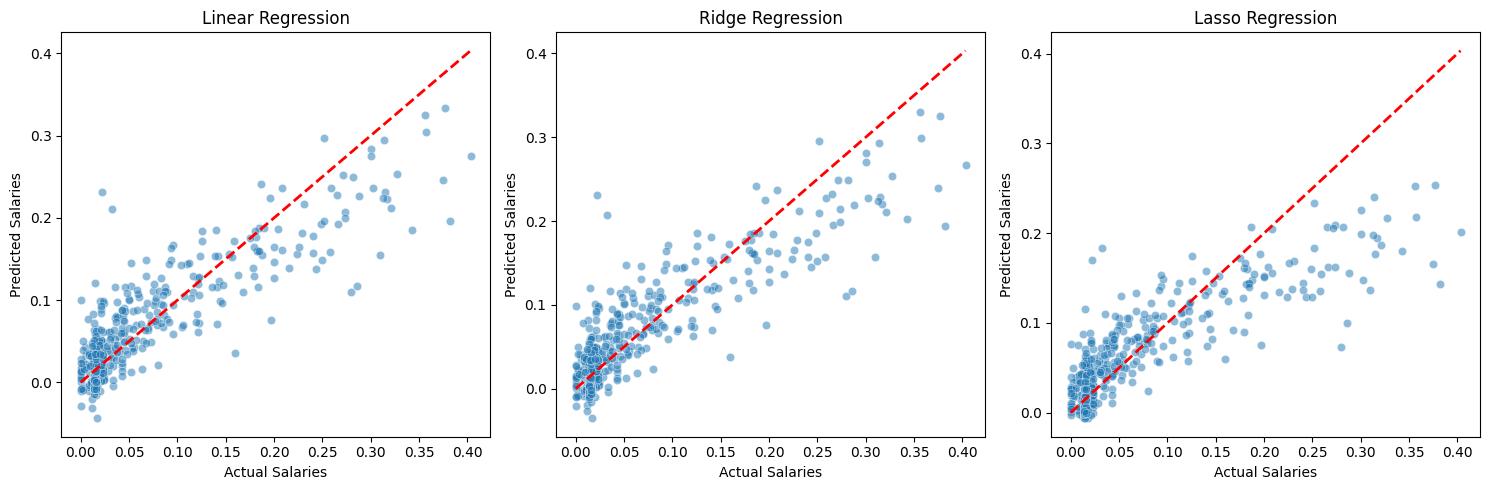

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('/content/final_nba_data2.csv')
data.dropna(inplace=True)

# Display the first few rows of the dataset to check the data

# Define X and y
X = data.drop(['target','salary','name','ORB','Pos','start','end','birth'],axis=1)
y = data['target']

# Combine X and y for correlation calculation
df = X.copy()
df['target'] = y

# Calculate correlation matrix
correlation_matrix = df.corr()
target_correlations = correlation_matrix['target'].drop('target')
sorted_correlations = target_correlations.abs().sort_values(ascending=False)

best_r2_score = 0
best_N = 0
best_features = None
target_length = len(target_correlations.tolist()) + 1

# Model to use for evaluation
best_model = LinearRegression()

for N in range(1, target_length):
    top_N_features = sorted_correlations.head(N).index
    top_N_feature_data = X[top_N_features]
    train_X, test_X, train_y, test_y = train_test_split(top_N_feature_data, y, test_size=0.3, random_state=42)

    best_model.fit(train_X, train_y)
    test_predictions = best_model.predict(test_X)

    r2 = r2_score(test_y, test_predictions)
    if r2 > best_r2_score:
        best_r2_score = r2
        best_N = N
        best_features = top_N_features

# best_features에 해당하는 상위 N개의 상관계수 값을 가져오기
top_correlations = sorted_correlations[best_features]

plt.figure(figsize=(10, 8))
sns.barplot(x=top_correlations, y=best_features, palette='viridis')
plt.title('Top Features Correlated with Target')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

print(f"Top {best_N} Features R2 Score: {best_r2_score}")

# Split the data into training and testing sets with the best features
X_train, X_test, y_train, y_test = train_test_split(X[best_features], y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Make predictions with Linear Regression
y_pred_linear = linear_model.predict(X_test_scaled)

# Initialize and train the Ridge regression model
ridge_model = Ridge(alpha=5)
ridge_model.fit(X_train_scaled, y_train)

# Make predictions with Ridge Regression
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Initialize and train the Lasso regression model
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train_scaled, y_train)

# Make predictions with Lasso Regression
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Calculate evaluation metrics
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f'Linear Regression - Mean Squared Error: {mse_linear}, R^2 Score: {r2_linear}')
print(f'Ridge Regression - Mean Squared Error: {mse_ridge}, R^2 Score: {r2_ridge}')
print(f'Lasso Regression - Mean Squared Error: {mse_lasso}, R^2 Score: {r2_lasso}')

# Visualize the results
plt.figure(figsize=(15, 5))

# Linear Regression Plot
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_test, y=y_pred_linear, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.title('Linear Regression')

# Ridge Regression Plot
plt.subplot(1, 3, 2)
sns.scatterplot(x=y_test, y=y_pred_ridge, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.title('Ridge Regression')

# Lasso Regression Plot
plt.subplot(1, 3, 3)
sns.scatterplot(x=y_test, y=y_pred_lasso, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.title('Lasso Regression')

plt.tight_layout()
plt.show()
